<a href="https://colab.research.google.com/github/Asritha0606/GenerativeAI/blob/main/GenAI_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RAG Evaluation

What does evaluation means?

The difference between **Reference(human written)** and **Predicted(from the LLM)** response.

In [1]:
!pip install -q groq langchain-groq litellm chromadb text-generation langchain sentence-transformers langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.9 MB/s eta 0:

In [2]:
import os
from google.colab import userdata
groq_api_key = userdata.get('groq_api')
os.environ["GROQ_API_KEY"] = groq_api_key

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)

In [4]:
#imports for RAG
import langchain
from langchain.document_loaders import TextLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from chromadb.utils import embedding_functions
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate

#imports for Evaluation
import pandas as pd
import numpy as np
from langchain.evaluation import Criteria
from langchain.evaluation import load_evaluator
from langchain.evaluation import EvaluatorType
from langchain.evaluation import EmbeddingDistance
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
loader = TextLoader('/content/state_of_the_union.txt')
data = loader.load()
data

[Document(metadata={'source': '/content/state_of_the_union.txt'}, page_content='Title - From Time to Time: History of the State of the Union\n\n"The President shall from time to time give to Congress information of the State of the Union and recommend to their Consideration such measures as he shall judge necessary and expedient." Article II, Sec. 3, U.S. Constitution\n\nGeorge Washington rode on a carriage driven by six horses from his house on Cherry Street to Federal Hall in New York to give his deliver his first annual message in person.\nOn a cold January morning, the President rode in a carriage drawn by six horses from his residence on Cherry Street in New York to Federal Hall for a joint meeting of the two bodies of Congress, the House of Representatives and the Senate. When George Washington personally delivered the first annual message to Congress on January 8, 1790, he was aware of his constitutional duty to deliver his message and of the precedent he was setting for future 

In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)
docs = text_splitter.split_documents(data)

In [7]:
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

<ipython-input-7-3917115723>:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
vectordb = Chroma.from_documents(docs, embeddings)
retriever=vectordb.as_retriever(search_type="mmr",search_kwargs={"k":1})

In [9]:
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7afd4d58b350>, search_type='mmr', search_kwargs={'k': 1})

In [10]:
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="refine", retriever=retriever, return_source_documents=False)

In [11]:
def query_llm(query):
  result = qa.run({"query": query})
  return result

query="What constitutional requirement mandates the President to deliver the State of the Union address?"
result = query_llm(query)
print(result)

<ipython-input-11-3696668616>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa.run({"query": query})


The constitutional requirement that mandates the President to deliver the State of the Union address is found in Article II, Section 3 of the United States Constitution, which states:

"The President shall from time to time give to Congress Information of the State of the Union, and recommend to their Consideration such Measures as he shall judge necessary and expedient..."

This provision requires the President to periodically report to Congress on the state of the nation, which is typically done through the State of the Union address.


## Exact Match

Gives a binary output when the prediction and reference matches exactly or not.

Either 0(even if a single word is mis matched) or 1(exact match)

In [12]:
from langchain.evaluation import ExactMatchStringEvaluator

exact_match_evaluator = ExactMatchStringEvaluator()
exact_match_evaluator = ExactMatchStringEvaluator(ignore_case=True)
exact_match_evaluator.evaluate_strings(
    prediction="Data Analyst",
    reference="Data Scientist",
)


{'score': 0}

## Cosine similarity

Measures the similarity between two vectors in a multi-dimensional space.

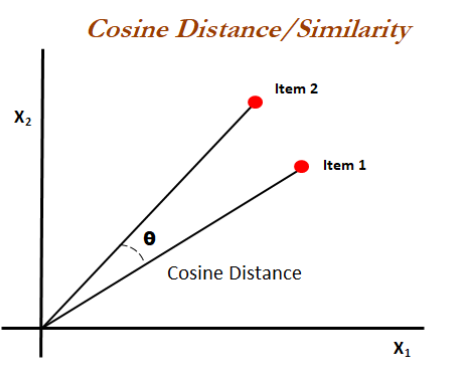

- The closer the vectors, the smaller the angle, the nearer the vectors. Means very similar.
 - cos 0 = 1
 - So if u get 1, means similar sentences.

- The farther the vectors, the wider the angle, the farther the vectors. Means NOT similar.
 - cos 90 = 0
 - So if u get 0, means dis-similar sentences.


- Range lies between 0 and 1

  - 0 means bad result/no matching

  - 1 means exact match





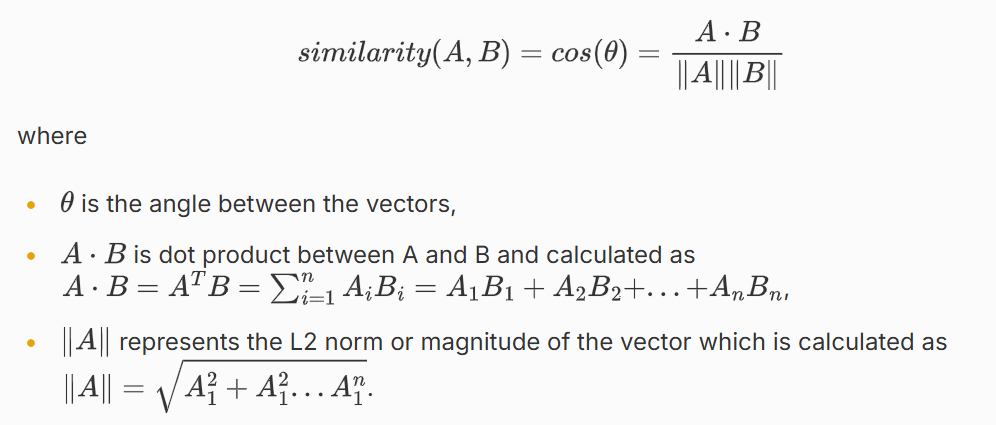

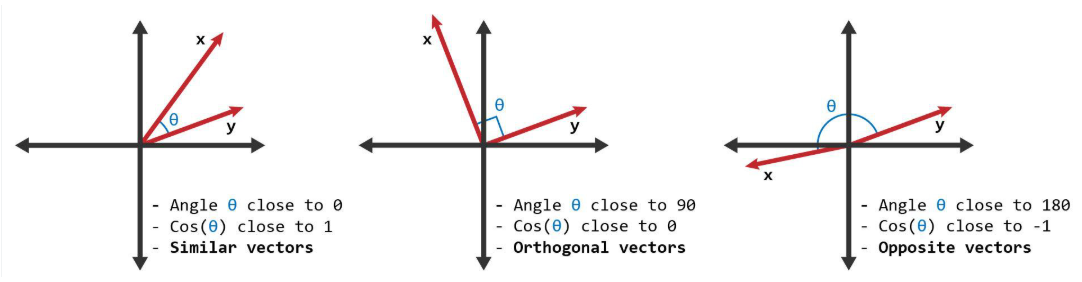

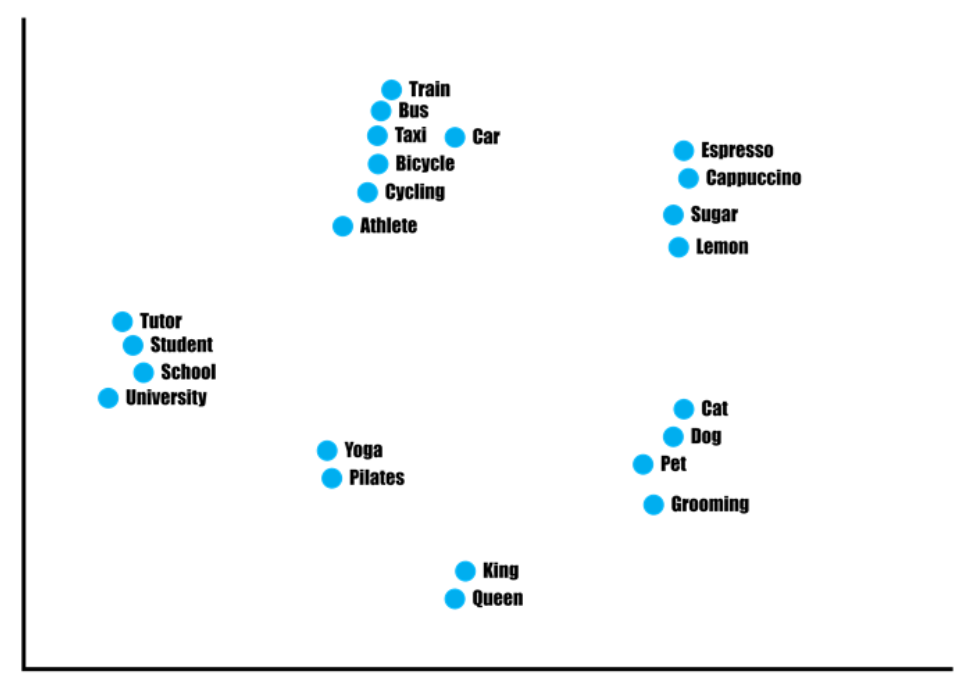

In [13]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def sentence_similarity(sentence1, sentence2):
    # Load the sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Compute the embeddings for the two sentences
    sentence1_embedding = model.encode([sentence1]) #reference
    sentence2_embedding = model.encode([sentence2]) #prediction

    # Calculate the cosine similarity between the two sentences
    similarity = cosine_similarity(sentence1_embedding, sentence2_embedding)[0]

    return similarity

#find the angle between the two embeddings in cosine similarity


Answers must be Human Written for 100% authenticity of the answer.

In [14]:
sentence1="""The constitutional requirement that mandates the President to deliver the State of the Union address is Article II, Section 3 of the United States Constitution, which states:"The President shall from time to time give to Congress Information of the State of the Union, and recommend to their Consideration such Measures as he shall judge necessary and expedient..."This provision requires the President to periodically report to Congress on the state of the nation, which is typically done through the State of the Union address."""
sentence2="""Article II, Section 3 of the U.S. Constitution requires the President to provide Congress with information on the State of the Union and recommend measures deemed necessary and expedient."""

similarity_score = sentence_similarity(sentence1, sentence2)

print(f"Cosine similarity between the two sentences: {similarity_score}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine similarity between the two sentences: [0.8227532]


## Langchain Evaluation Criteria

https://python.langchain.com/api_reference/langchain/evaluation/langchain.evaluation.criteria.eval_chain.Criteria.html

In [15]:
print(list(Criteria))

[<Criteria.CONCISENESS: 'conciseness'>, <Criteria.RELEVANCE: 'relevance'>, <Criteria.CORRECTNESS: 'correctness'>, <Criteria.COHERENCE: 'coherence'>, <Criteria.HARMFULNESS: 'harmfulness'>, <Criteria.MALICIOUSNESS: 'maliciousness'>, <Criteria.HELPFULNESS: 'helpfulness'>, <Criteria.CONTROVERSIALITY: 'controversiality'>, <Criteria.MISOGYNY: 'misogyny'>, <Criteria.CRIMINALITY: 'criminality'>, <Criteria.INSENSITIVITY: 'insensitivity'>, <Criteria.DEPTH: 'depth'>, <Criteria.CREATIVITY: 'creativity'>, <Criteria.DETAIL: 'detail'>]


## Create your Evaluator

In [16]:
from langchain.evaluation import load_evaluator
evaluator = load_evaluator("criteria", criteria="conciseness", llm=llm)
eval_result = evaluator.evaluate_strings(
    input="""What constitutional duty mandates the President to deliver the State of the Union message?""",
    prediction="""The constitutional requirement that mandates the President to deliver the State of the Union address is Article II,
    Section 3 of the United States Constitution, which states:"The President shall from time to time give to Congress Information of
    the State of the Union, and recommend to their Consideration such Measures as he shall judge necessary and expedient..."This provision
    requires the President to periodically report to Congress on the state of the nation, which is typically done through the State of the
    Union address.""",
    reference="""Article II, Section 3 of the U.S. Constitution requires the President to provide Congress with information on the State of the Union and recommend measures deemed necessary and expedient."""
   )
print(eval_result)

/usr/local/lib/python3.11/dist-packages/langchain/evaluation/schema.py:130: UserWarning: Ignoring reference in CriteriaEvalChain, as it is not expected.
To use references, use the labeled_criteria instead.
  warn(self._skip_reference_warning)


{'reasoning': "To determine if the submission meets the criteria, I will analyze it step by step.\n\n1. **Conciseness**: \n   - The submission provides a clear and direct answer to the question.\n   - It cites the specific constitutional provision (Article II, Section 3) that mandates the President to deliver the State of the Union message.\n   - The submission also provides a brief explanation of the provision, which helps to clarify the requirement.\n   - However, the submission is not extremely brief; it includes a quote from the Constitution and a short explanation of the provision's purpose.\n   - Considering the need for clarity and the inclusion of relevant information, the submission's length is acceptable.\n\nBased on this analysis, I conclude that the submission meets the criterion of conciseness.\n\nY", 'value': 'Y', 'score': 1}


In [17]:
from IPython.display import display,Markdown
display(Markdown(str(eval_result)))

{'reasoning': "To determine if the submission meets the criteria, I will analyze it step by step.\n\n1. **Conciseness**: \n   - The submission provides a clear and direct answer to the question.\n   - It cites the specific constitutional provision (Article II, Section 3) that mandates the President to deliver the State of the Union message.\n   - The submission also provides a brief explanation of the provision, which helps to clarify the requirement.\n   - However, the submission is not extremely brief; it includes a quote from the Constitution and a short explanation of the provision's purpose.\n   - Considering the need for clarity and the inclusion of relevant information, the submission's length is acceptable.\n\nBased on this analysis, I conclude that the submission meets the criterion of conciseness.\n\nY", 'value': 'Y', 'score': 1}

## Custom criteria

In [18]:
custom_criteria = {
    "numeric": "Does the output contain numeric information?",
    "mathematical": "Does the output contain mathematical information?"
}
prompt = "Tell me a joke"

output = """
Why was the equal sign so humble?

Because it knew it wasn’t less than or greater than anyone!
"""
eval_chain = load_evaluator(
    EvaluatorType.CRITERIA,
    criteria=custom_criteria,
    llm=llm
)
eval_result = eval_chain.evaluate_strings(prediction = output, input = prompt)
print("===================== Multi-criteria evaluation =====================")
print(eval_result)


===================== Multi-criteria evaluation =====================
{'reasoning': 'To assess the submission against the given criteria, I will follow these steps:\n\n**Numeric Criterion:**\n1. The submission is a joke, which typically involves words and phrases rather than numbers.\n2. Upon reviewing the submission, I see that it contains words like "less than" and "greater than," which are mathematical concepts, but they are not presented as numbers.\n3. The submission does not contain any explicit numeric information, such as numbers or quantities.\n4. Therefore, based on the information provided, the submission does not meet the numeric criterion.\n\n**Mathematical Criterion:**\n1. The submission contains the phrase "less than or greater than," which is a mathematical concept.\n2. The phrase is used in a humorous way to make a point about the equal sign, but it is still a mathematical concept.\n3. The submission does not contain any mathematical operations or equations, but it doe

In [19]:
from IPython.display import display,Markdown
display(Markdown(str(eval_result)))

{'reasoning': 'To assess the submission against the given criteria, I will follow these steps:\n\n**Numeric Criterion:**\n1. The submission is a joke, which typically involves words and phrases rather than numbers.\n2. Upon reviewing the submission, I see that it contains words like "less than" and "greater than," which are mathematical concepts, but they are not presented as numbers.\n3. The submission does not contain any explicit numeric information, such as numbers or quantities.\n4. Therefore, based on the information provided, the submission does not meet the numeric criterion.\n\n**Mathematical Criterion:**\n1. The submission contains the phrase "less than or greater than," which is a mathematical concept.\n2. The phrase is used in a humorous way to make a point about the equal sign, but it is still a mathematical concept.\n3. The submission does not contain any mathematical operations or equations, but it does use mathematical terminology.\n4. Therefore, based on the information provided, the submission meets the mathematical criterion.\n\nBased on the assessment, the submission meets the mathematical criterion but does not meet the numeric criterion.\n\nY', 'value': 'Y', 'score': 1}

## Scores: BLEU, ROUGE, METEOR



BLEU:

- BiLingual Evaluation Understudy

- Precision based

- measures of how many words in the machine-generated text appearing in the reference human-generated text.

- compares LLM output with Human input

- The basic idea is to evaluate precision by calculating the count of n-grams (number of n words), in the generated text appearing in the reference.

ROUGE:

- Recall-Oriented Understudy for Gisting Evaluation

- Recall based

- For summarisation

Key ROUGE Metrics

- **ROUGE-N**: It measures the n-gram overlap between the generated text and reference text.

- **ROUGE-L**: It takes the longest common subsequences (LCS), that are useful for capturing structural similarity.

- **ROUGE-W**: It weighs contiguous matches that are higher than other n-grams.

- **ROUGE-S**: It measures skip-bigram overlap, where two words are considered, but they may not be adjacent.

**Difference between BLEU and ROUGE**:

The difference is that with ROUGE we
check how many n-grams in the reference text also occur in the generated text. For
BLEU we looked at how many n-grams in the generated text appear in the reference.

**When to use which one?**

- BLEU is used for tasks where precision is important, such as machine translation, where it is necessary to generate grammatically and contextually correct sentences.

- ROUGE, on the other hand, is recall-oriented, making it better for summarization tasks where it is more important to capture all key points rather than the exact phrasing.

**Note on Precision and Recall**

Precision:

- It measures the accuracy of positive predictions.
- Precision = True Positives / (True Positives + False Positives)

Recall:

- It measures the model's ability to find all the positive instances.
- Recall = True Positives / (True Positives + False Negatives)

In [20]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [21]:
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [22]:
# Importing evaluate library
import evaluate

# Load the BLEU and ROUGE metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Example sentences (non-tokenized)
reference = ["the cat is on the mat"]
candidate = ["the cat is on mat"]

# BLEU expects plain text inputs
bleu_results = bleu_metric.compute(predictions=candidate, references=reference)
print(f"BLEU Score: {bleu_results['bleu'] * 100:.2f}")

# ROUGE expects plain text inputs
rouge_results = rouge_metric.compute(predictions=candidate, references=reference)

# Access ROUGE scores (no need for indexing into the result)
print(f"ROUGE-1 F1 Score: {rouge_results['rouge1']:.2f}")
print(f"ROUGE-L F1 Score: {rouge_results['rougeL']:.2f}")

BLEU Score: 57.89
ROUGE-1 F1 Score: 0.91
ROUGE-L F1 Score: 0.91
